### Import Libraries

In [2]:
import pandas as pd
import numpy as np
# from together import Together
import time
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import warnings
from openai import OpenAI
warnings.filterwarnings('ignore')

### Load Datasets

In [3]:
train_data = pd.read_excel('lab-manual-mm-train-5768.xlsx')
test_data = pd.read_excel('lab-manual-mm-test-5768.xlsx')

fomc_sentences = pd.read_csv('processed_minutes.csv')

In [4]:
togetherai_api_key = 'dd7aaa683f7a978000e2f6b9bb6df2a3ab1d7ecb7dc0aa248c989c1118a0c463'
client_together = OpenAI(api_key=togetherai_api_key,
                base_url='https://api.together.xyz')

### Performance Metric Functions

In [5]:
def evaluate_performance(y_true, y_pred):
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'valid_predictions': len(y_pred),
#         'total_samples': len(y_pred)
    }

In [6]:
def getPerformanceMetrics(results, label):
    results['predicted_label'] = pd.to_numeric(results['predicted_label'], errors='coerce')
    results['true_label'] = pd.to_numeric(results['true_label'], errors='coerce')
#     results['latency'] = pd.to_numeric(results['latency'], errors='coerce')

    metrics = evaluate_performance(
        results['true_label'], 
        results['predicted_label']
    )
    print( label + "Performance:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"F1 Score: {metrics['f1_macro']:.3f}")
    print(f"Average Latency: {results['latency'].mean():.2f} seconds")
    print(f"Valid predictions: {metrics['valid_predictions']}/{len(test_data)}")


### Functions to Create Prompts for Zero/Few Shots 

In [31]:
def create_prompt(sentence, examples=None):
    if examples is None:
        # Zero-shot prompt
        return f"""Classify this Federal Reserve statement with a single number:
        0 for Dovish (looser monetary policy)
        1 for Hawkish (tighter monetary policy)
        2 for Neutral
        
        Statement: {sentence}
        Classification:"""
    else:
        examples_text = "\n".join([f"Statement: {text}\nClassification: {label}" for text, label in examples])
        prompt = f"""Classify Federal Reserve statements with:
                        0 for Dovish (looser monetary policy)
                        1 for Hawkish (tighter monetary policy)
                        2 for Neutral
                        Examples:
                        {examples_text}

                        Statement: {sentence}
                        Classification:"""
        return prompt

def get_few_shot_examples(train_df):
    examples = []
    for label in [0, 1, 2]:
        example = train_df[train_df['label'] == label].iloc[0]
        examples.append((example['sentence'], label))
    return examples

def get_few_shot_biased_examples(train_df):
    examples = []
    for label in [0, 1, 2]:
        samples = train_df[train_df['label'] == label].sample(n=2)
        for _, example in samples.iterrows():
            examples.append((example['sentence'], label))
        # examples.append((example['sentence'], label))
    return examples


### Main Function to Classify LLM prompts

In [ ]:
def classify_statements(client, statements_df, train_df=None):
    examples = get_few_shot_biased_examples(train_df) if train_df is not None else None
    if(examples):
        print(examples)
    results = []
    # statements_df = statements_df.head(5)
    count = 0
    total = len(statements_df)

    model_source = 'meta-llama'

    model_name = 'Llama-3-70b-chat-hf'

    model_str = f'{model_source}/{model_name}'
    
    for _, row in statements_df.iterrows():
        count=count+1
        prompt = create_prompt(row['sentence'], examples)
#         if(count==1):
#             print(prompt)
        prompt_json = [{'role': 'user', 'content': prompt}]
        start_time = time.time()
        chat_completion = client_together.chat.completions.create(model=model_str,
                                                          messages=prompt_json,
                                                          temperature=0,
                                                          max_tokens=100)

        response = chat_completion.choices[0].message.content
        # print(chat_completion)
        end_time = time.time()

        label = None
        for char in response:
            if char in ['0', '1', '2']:
                label = char
                break

        results.append({
            'sentence': row['sentence'],
            'predicted_label': label,
            'true_label': row.get('label', None),
            'latency': end_time - start_time
        })
        if(count%10==0):
            print("Processed " + str(count) + " out of " + str(total) + " sentences")

        # time.sleep(0.5)
    
    return pd.DataFrame(results)

### ZERO SHOT INFERENCE

In [12]:
zero_shot_results = classify_statements(
    client_together, 
    test_data, None
)

Processed 10 out of 214 sentences
Processed 20 out of 214 sentences
Processed 30 out of 214 sentences
Processed 40 out of 214 sentences
Processed 50 out of 214 sentences
Processed 60 out of 214 sentences
Processed 70 out of 214 sentences
Processed 80 out of 214 sentences
Processed 90 out of 214 sentences
Processed 100 out of 214 sentences
Processed 110 out of 214 sentences
Processed 120 out of 214 sentences
Processed 130 out of 214 sentences
Processed 140 out of 214 sentences
Processed 150 out of 214 sentences
Processed 160 out of 214 sentences
Processed 170 out of 214 sentences
Processed 180 out of 214 sentences
Processed 190 out of 214 sentences
Processed 200 out of 214 sentences
Processed 210 out of 214 sentences


In [13]:
zero_shot_results_f = zero_shot_results.dropna(subset=['predicted_label'])

In [14]:
getPerformanceMetrics(zero_shot_results_f, "Zero Shot Results:")

Zero Shot Results:Performance:
Accuracy: 0.651
F1 Score: 0.647
Average Latency: 1.72 seconds
Valid predictions: 212/214


In [314]:
print(evaluate_performance(
        zero_shot_results_f['true_label'], 
        zero_shot_results_f['predicted_label']
    ))

{'accuracy': 0.6509433962264151, 'f1_macro': 0.6473354377602951, 'precision_macro': 0.6828990368077056, 'recall_macro': 0.6305658865457993, 'valid_predictions': 212}


### FEW SHOTS INFERENCE

In [15]:
few_shot_results = classify_statements(
    client_together, 
    test_data, train_data
)

[('A few participants particularly stressed the high uncertainty associated with the expected future path of the unemployment rate and commented that the unemployment rate could rise by considerably more than in the staff forecast.', 0), ('These included a decline in the cost of business capital, a recent rise in orders and backlogs of nondefense capital goods, persisting gains in productivity that undoubtedly pointed to growing profit opportunities, progress in strengthening business balance sheets, and reduced capital overhangs.', 1), ('In light of these uncertainties as well as continued evidence of muted inflation pressures, participants generally agreed that a patient approach to determining future adjustments to the target range for the federal funds rate remained appropriate.', 2)]
Processed 10 out of 214 sentences
Processed 20 out of 214 sentences
Processed 30 out of 214 sentences
Processed 40 out of 214 sentences
Processed 50 out of 214 sentences
Processed 60 out of 214 senten

In [16]:
few_shot_results_f = few_shot_results.dropna(subset=['predicted_label'])

In [17]:
getPerformanceMetrics(few_shot_results_f, "Few shots performance:")

Few shots performance:Performance:
Accuracy: 0.678
F1 Score: 0.682
Average Latency: 1.73 seconds
Valid predictions: 214/214


In [315]:
print(evaluate_performance(
        few_shot_results_f['true_label'], 
        few_shot_results_f['predicted_label']
    ))

{'accuracy': 0.677570093457944, 'f1_macro': 0.6819974373931208, 'precision_macro': 0.6762342526387469, 'recall_macro': 0.6899462683624175, 'valid_predictions': 214}


### ROBERTA Model Load and inference

In [18]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")


In [21]:
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=-1, framework="pt")

In [22]:
start_time = time.time()
results = classifier(test_data['sentence'].tolist(), 
                      batch_size=128, truncation="only_first")

end_time = time.time()

In [ ]:
predicted_labels = [int(result['label'].replace('LABEL_', '')) for result in results]

roberta_time_taken =  end_time - start_time

roberta_results = pd.DataFrame({
    'sentence': test_data['sentence'],
    'true_label': test_data['label'],
    'predicted_label': predicted_labels,
})

In [24]:
print(evaluate_performance(test_data['label'], predicted_labels))
print(roberta_time_taken/len(test_data))

{'accuracy': 0.8738317757009346, 'f1_macro': 0.8747528613665633, 'precision_macro': 0.8699753896636587, 'recall_macro': 0.8806997436655822, 'valid_predictions': 214}
0.6354727990159365


### Saving Outputs of all 3 models

In [25]:
zero_shot_results.to_csv('zero_shot.csv', index=False)
few_shot_results.to_csv('few_shot.csv', index=False)
roberta_results.to_csv('roberta.csv', index=False)


### Testing for other cases of few shots (using get_few_shot_biased_examples temporarily)

In [33]:
few_shot_biased_results = classify_statements(
    client_together, 
    test_data, train_data
)

[('Expectations of greater and longer-lasting slack in labor and product markets than anticipated earlier had led to downward revisions to forecasts of wage and price inflation.', 0), ('Investor perceptions of a somewhat less accommodative tone of Federal Reserve communications, as well as the softer-than-expected reading for the April CPI, likely contributed to the decline in inflation compensation.', 0), ('Geopolitical uncertainties, notably those relating to developments in Iraq, frequently were cited by business contacts as a major reason for caution, but other factors inhibiting capital expenditures evidently included excess capacity and limited prospects for profits because of increased energy, insurance, pension, and other costs and a concomitant inability to raise selling prices.', 1), ('Measures of inflation compensation based on Treasury Inflation-Protected Securities (TIPS) edged up, on net, remaining close to their pre-pandemic levels.', 1), ('In keeping with the practice a

In [34]:
few_shot_biased_results_f = few_shot_biased_results.dropna(subset=['predicted_label'])
getPerformanceMetrics(few_shot_biased_results_f, "Few shots performance:")

Few shots performance:Performance:
Accuracy: 0.664
F1 Score: 0.661
Average Latency: 1.81 seconds
Valid predictions: 214/214


In [316]:
print(evaluate_performance(
        few_shot_biased_results_f['true_label'], 
        few_shot_biased_results_f['predicted_label']
    ))

{'accuracy': 0.6635514018691588, 'f1_macro': 0.6610176034154165, 'precision_macro': 0.7191558441558442, 'recall_macro': 0.6524049837326235, 'valid_predictions': 214}


In [37]:
print("foo")
fomc_sentences[:10]

foo


,date,filename,sentence
0,2022-09-21,20220921.txt,equity prices initially rose amid secondquarte...
1,2022-09-21,20220921.txt,regarding international developments yields in...
2,2022-09-21,20220921.txt,the markets for treasury securities and agency...
3,2022-09-21,20220921.txt,amid strong demand for shortterm investments t...
4,2022-09-21,20220921.txt,issuance of shortterm securities was likely to...
5,2022-09-21,20220921.txt,labor demand remained strong and the labor mar...
6,2022-09-21,20220921.txt,recent monthly readings indicated that consume...
7,2022-09-21,20220921.txt,total nonfarm payroll employment posted robust...
8,2022-09-21,20220921.txt,the unemployment rate edged up on net from 3.6...
9,2022-09-21,20220921.txt,the unemployment rate for african americans in...


### FOMC Sentence Hawkishness  CLassifications

In [ ]:
def analyze_hawkishness_score_for_sample(client, sampled_df, train_data):    
    classifications = classify_statements(client, sampled_df, train_data)
    classifications['year'] = sampled_df['year']
    
    classifications.to_csv('fomc_classifications2.csv', index=False)
    yearly_scores = classifications.groupby('year').agg({
        'predicted_label': [
            ('hawkish', lambda x: sum(x == '1')),
            ('dovish', lambda x: sum(x == '0')),
            ('total', 'count')
        ]
    })
    
    yearly_scores.columns = ['hawkish', 'dovish', 'total']
    
    yearly_scores['hawkishness_score'] = round((yearly_scores['hawkish'] - yearly_scores['dovish']) / yearly_scores['total'], 3)
    
    return yearly_scores.reset_index()

In [47]:
fomc_sentences['year'] = pd.to_datetime(fomc_sentences['date']).dt.year
sampled_sentences = []
for year in fomc_sentences['year'].unique():
    year_data = fomc_sentences[fomc_sentences['year'] == year]
    if len(year_data) > 100:
        sampled_sentences.append(year_data.sample(n=100, random_state=42))
    else:
        sampled_sentences.append(year_data)
sampled_df = pd.concat(sampled_sentences, ignore_index=True)

In [48]:
hawkishscore_result = analyze_hawkishness_score_for_sample(client_together, sampled_df, train_data)

[("Some participants also noted that recent readings on some survey measures of consumers' inflation expectations had declined or stood at historically low levels.", 0), ('However, core inflation had been subdued in recent months and longer-run inflation expectations remained contained.', 0), ('Most major indexes of equity prices moved up sharply on the bullish economic reports.', 1), ('Staff Economic Outlook The projection for U. S. economic activity prepared by the staff for the April–May FOMC meeting was revised up on net.', 1), ('Labor markets appeared to be stabilizing as private nonfarm payrolls grew in September for the first time since January, and employment losses in July and August turned out to be smaller than data initially had indicated.', 2), ('Broad stock price indexes rose, on net, over the intermeeting period, as investors responded to strong second-quarter earnings reports and indications that the economy may be stabilizing.', 2)]
Processed 10 out of 2900 sentences
P

### Hawkishness Results

In [49]:
hawkishscore_result

,year,hawkish,dovish,total,hawkishness_score
0,1996,23,22,100,0.01
1,1997,33,29,100,0.04
2,1998,31,20,100,0.11
3,1999,33,18,100,0.15
4,2000,34,26,100,0.08
5,2001,14,50,100,-0.36
6,2002,20,46,100,-0.26
7,2003,18,53,100,-0.35
8,2004,34,27,100,0.07
9,2005,27,27,100,0.00


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

msf_data = pd.read_csv('MSF_1996_2023.csv')

In [51]:
all_data = msf_data

In [55]:
def map_industry(siccd):
    if 1 <= siccd <= 999:
        return "Agriculture, Forestry and Fishing"
    elif 1000 <= siccd <= 1499:
        return "Mining"
    elif 1500 <= siccd <= 1799:
        return "Construction"
    elif 2000 <= siccd <= 3999:
        return "Manufacturing"
    elif 4000 <= siccd <= 4999:
        return "Transportation and other Utilities"
    elif 5000 <= siccd <= 5199:
        return "Wholesale Trade"
    elif 5200 <= siccd <= 5999:
        return "Retail Trade"
    elif 6000 <= siccd <= 6799:
        return "Finance, Insurance and Real Estate"
    elif 7000 <= siccd <= 8999:
        return "Services"
    else:
        return "Public Administration"

def map_industry_code(siccd):
    if 1 <= siccd <= 999:
        return 10
    elif 1000 <= siccd <= 1499:
        return 1
    elif 1500 <= siccd <= 1799:
        return 2
    elif 2000 <= siccd <= 3999:
        return 3
    elif 4000 <= siccd <= 4999:
        return 4
    elif 5000 <= siccd <= 5199:
        return 5
    elif 5200 <= siccd <= 5999:
        return 6
    elif 6000 <= siccd <= 6799:
        return 7
    elif 7000 <= siccd <= 8999:
        return 8
    else:
        return 9

industry_labels = [
    "Agriculture, Forestry and Fishing",
    "Mining",
    "Construction",
    "Manufacturing",
    "Transportation and other Utilities",
    "Wholesale Trade",
    "Retail Trade",
    "Finance, Insurance and Real Estate",
    "Services",
    "Public Administration"
]
def map_industry_code(siccd):
    if 1 <= siccd <= 999:
        return 10
    elif 1000 <= siccd <= 1499:
        return 1
    elif 1500 <= siccd <= 1799:
        return 2
    elif 2000 <= siccd <= 3999:
        return 3
    elif 4000 <= siccd <= 4999:
        return 4
    elif 5000 <= siccd <= 5199:
        return 5
    elif 5200 <= siccd <= 5999:
        return 6
    elif 6000 <= siccd <= 6799:
        return 7
    elif 7000 <= siccd <= 8999:
        return 8
    else:
        return 9

### MSF Data Set preparation for Trade Strategy

In [53]:
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['SICCDINT'] = pd.to_numeric(all_data['SICCD'], errors='coerce')
all_data = all_data.dropna(subset=['SICCDINT'])
all_data['industry'] = all_data['SICCDINT'].apply(map_industry)
all_data['RET'] = pd.to_numeric(all_data['RET'], errors='coerce')
all_data['vwretd'] = pd.to_numeric(all_data['vwretd'], errors='coerce')
all_data = all_data.dropna(subset=['RET', 'vwretd'])
all_data['Year'] = all_data['date'].dt.year
msf_data_f = all_data.copy(deep=True)

In [54]:
msf_data_f = msf_data_f[(msf_data_f['Year'] >= 1996) & (msf_data_f['Year'] <= 2025)]

In [ ]:
def make_features(df, lookback):
    features = []
    for _, group in df.groupby('PERMNO'):
        group = group.sort_values('date')        
        group['return'] = group['RET'].pct_change()      
        group['beta'] = group['RET']/ group['vwretd']
        group['industry_code'] = group['SICCDINT'].apply(map_industry_code)
        group['momentum'] = group['PRC'].pct_change(periods=lookback)

        group['Month'] = group['date'].dt.month

        group['volatility'] = group['return'].rolling(window=lookback).std()

        yearly_total_return = group.groupby('Year')['return'].sum()  
        yearly_avg_beta = group.groupby('Year')['beta'].mean().shift(1) 
        
        group = group.merge(yearly_total_return.rename('total_return'), on='Year', how='left')
        group = group.merge(yearly_avg_beta.rename('avg_beta'), on='Year', how='left')
        
        
        lagged_features = []
        for i in range(1, lookback + 1):
            lagged = group[['return', 'momentum', 'volatility']].shift(i)
            lagged.columns = [f'{col}_lag{i}' for col in lagged.columns]
            lagged_features.append(lagged)

        features_group = pd.concat([
            group[['PERMNO', 'date', 'RET', 'vwretd', 'beta', 'industry_code', 'industry', 'PRC', 'Year', 'avg_beta', 'total_return', 'Month']],
            group[['return', 'momentum', 'volatility']].shift(1), 
             *lagged_features,
        ], axis=1)

        features_group = features_group[features_group['Month'] == 1]

    
        features.append(features_group.dropna())
#         print(features)
    
    return pd.concat(features, ignore_index=True)

In [57]:
msf_data_relevant_f = make_features(msf_data_f, 6)

In [58]:
msf_data_relevant_f[:5]

,PERMNO,date,RET,vwretd,beta,industry_code,industry,PRC,Year,avg_beta,...,volatility_lag3,return_lag4,momentum_lag4,volatility_lag4,return_lag5,momentum_lag5,volatility_lag5,return_lag6,momentum_lag6,volatility_lag6
0,10001,2001-01-31,0.012821,0.039573,0.323984,4,Transportation and other Utilities,9.875,2001,0.174771,...,1.658286,0.590920,-2.093750,1.558971,-4.047616,0.000000,0.933318,-1.564732,-0.030769,0.577609
1,10001,2002-01-31,-0.013100,-0.015966,0.820494,4,Transportation and other Utilities,11.300,2002,0.001942,...,2.025379,-2.058129,0.195000,1.839337,-0.187343,0.266667,2.104097,-0.778831,0.225316,1.933244
2,10001,2003-01-31,0.148143,-0.023367,-6.339838,4,Transportation and other Utilities,8.440,2003,0.621696,...,4.956557,-1.098291,-0.158654,2.184818,-1.171784,-0.168224,2.158938,3.155313,-0.225664,2.434177
3,10001,2004-01-30,0.010084,0.023042,0.437636,4,Transportation and other Utilities,6.010,2004,-2.766254,...,2.776029,-0.565894,-0.098039,2.451592,3.731519,-0.239130,2.962555,-1.063571,-0.274882,2.069650
4,10001,2005-01-31,-0.040580,-0.026546,1.528667,4,Transportation and other Utilities,6.620,2005,-1.176643,...,13.821668,-31.865609,-0.158621,13.795592,-0.916045,0.083205,2.837035,3.806157,0.164725,3.464186


In [59]:
msf_features = ['Year', 'date','PERMNO', 'beta', 'vwretd', 'industry_code', 'volatility' , 'return', 'momentum', 'industry', 'avg_beta', 'total_return']
msf_data_final = msf_data_relevant_f[msf_features]

In [60]:
msf_data_final

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return
0,2001,2001-01-31,10001,0.323984,0.039573,4,1.851994,-0.477120,0.218750,Transportation and other Utilities,0.174771,-18.972112
1,2002,2002-01-31,10001,0.820494,-0.015966,4,1.163830,-2.607069,-0.029661,Transportation and other Utilities,0.001942,12.318380
2,2003,2003-01-31,10001,-6.339838,-0.023367,4,4.413398,3.442682,-0.243724,Transportation and other Utilities,0.621696,-13.328321
3,2004,2004-01-30,10001,0.437636,0.023042,4,2.613611,-0.330000,-0.009983,Transportation and other Utilities,-2.766254,-20.393461
4,2005,2005-01-31,10001,1.528667,-0.026546,4,13.637655,4.171712,0.036036,Transportation and other Utilities,-1.176643,-7.854786
5,2006,2006-01-31,10001,-0.411634,0.040072,4,2.520469,-1.354446,0.071823,Transportation and other Utilities,2.994997,-16.952324
6,2007,2007-01-31,10001,1.200753,0.019387,4,3.232808,-1.724944,0.230599,Transportation and other Utilities,10.176558,-72.839971
7,2008,2008-01-31,10001,0.097753,-0.062218,4,34.502124,-1.049496,-0.057333,Transportation and other Utilities,-1.143205,-4.739194
8,2009,2009-01-30,10001,-0.440681,-0.077471,4,3.709671,-2.198800,-0.231628,Transportation and other Utilities,2.252687,17.418275
9,2010,2010-01-29,10001,0.509308,-0.037172,4,9.538883,21.920507,0.197688,Transportation and other Utilities,-0.170157,-54.041665


In [61]:
msf_data_final['total_return'] = msf_data_final['total_return'].replace([np.inf, -np.inf], np.nan)
msf_data_final = msf_data_final.dropna(subset=['total_return'])
msf_data_final['lag_total_returns'] = msf_data_final.groupby('PERMNO')['total_return'].shift(1)

In [62]:
msf_data_final

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns
0,2001,2001-01-31,10001,0.323984,0.039573,4,1.851994,-0.477120,0.218750,Transportation and other Utilities,0.174771,-18.972112,NaN
1,2002,2002-01-31,10001,0.820494,-0.015966,4,1.163830,-2.607069,-0.029661,Transportation and other Utilities,0.001942,12.318380,-18.972112
2,2003,2003-01-31,10001,-6.339838,-0.023367,4,4.413398,3.442682,-0.243724,Transportation and other Utilities,0.621696,-13.328321,12.318380
3,2004,2004-01-30,10001,0.437636,0.023042,4,2.613611,-0.330000,-0.009983,Transportation and other Utilities,-2.766254,-20.393461,-13.328321
4,2005,2005-01-31,10001,1.528667,-0.026546,4,13.637655,4.171712,0.036036,Transportation and other Utilities,-1.176643,-7.854786,-20.393461
5,2006,2006-01-31,10001,-0.411634,0.040072,4,2.520469,-1.354446,0.071823,Transportation and other Utilities,2.994997,-16.952324,-7.854786
6,2007,2007-01-31,10001,1.200753,0.019387,4,3.232808,-1.724944,0.230599,Transportation and other Utilities,10.176558,-72.839971,-16.952324
7,2008,2008-01-31,10001,0.097753,-0.062218,4,34.502124,-1.049496,-0.057333,Transportation and other Utilities,-1.143205,-4.739194,-72.839971
8,2009,2009-01-30,10001,-0.440681,-0.077471,4,3.709671,-2.198800,-0.231628,Transportation and other Utilities,2.252687,17.418275,-4.739194
9,2010,2010-01-29,10001,0.509308,-0.037172,4,9.538883,21.920507,0.197688,Transportation and other Utilities,-0.170157,-54.041665,17.418275


### Trading Strategy on Hawkish/Dovish (Threshold =0)

In [ ]:
def calculate_cumulative_returns(df, hawkish_dict, threshold):
    cumulative_returns = []
    cumulative_return = 0
    cumulative_market_return = 0

    for year in sorted(df['Year'].unique()):
        
        prev_year_score = hawkish_dict.get(year - 1)
        if (prev_year_score) == None:
            print("Skipping" + year)
            continue  
        # prev_year_score = prev_year_score[0]


        df_year = df[df['Year'] == year]
        df_year = df_year.dropna(subset=['lag_total_returns'])


        year_cumulative_return = 0
        selected_stocks = []
        
        if prev_year_score > threshold:
            
            hawkish_df = df_year[
                (df_year['industry'] == 'Finance, Insurance and Real Estate') &
                (df_year['avg_beta'].notnull())
            ]
            # Calculate stability as the absolute value of beta and select stocks closest to zero

            hawkish_df['beta_stability'] = hawkish_df['avg_beta'].abs()
            hawkish_df_sorted = hawkish_df.sort_values(by=['MarketCapWeight', 'beta_stability', 'lag_total_returns'], ascending=[False, True, False])
            # hawkish_df_sorted = hawkish_df.sort_values(by=['total_return'], ascending=[False])
            # Select the top 5 stocks based on the sorted criteria
            # num_selected = int(len(hawkish_df_sorted) * 0.2)
            selected_stocks = hawkish_df_sorted.head(10)
            print("Selected Stocks:")
            display(selected_stocks)

            # selected_stocks = hawkish_df.nsmallest(5, 'beta_stability')
            # year_cumulative_return = selected_stocks['total_return'].sum()/len(selected_stocks)

            year_cumulative_return = selected_stocks['total_return'].mean()

            # market_return = selected_stocks['vwretd'].mean() * 12

        else:
            dovish_df = df_year[
                (df_year['industry'].isin(['Services', 'Manufacturing'])) &
                ((df_year['lag_total_returns'] > 0) | (df_year['beta'] > 0))
            ]
            dovish_df_sorted = hawkish_df.sort_values(by=['MarketCapWeight', 'lag_total_returns'], ascending=[False, False])
            # num_selected = int(len(dovish_df_sorted) * 0.02)
            selected_stocks = dovish_df_sorted.head(10)
            # print(selected_stocks)
            # selected_stocks = dovish_df_sorted.head(5)
            # selected_stocks = dovish_df.nlargest(15, 'lag_total_returns')
            # year_cumulative_return = selected_stocks['total_return'].sum()/len(selected_stocks)
            year_cumulative_return = selected_stocks['total_return'].mean()

            # market_return = selected_stocks['vwretd'].mean() * 12
        # print(year)
        # print(year_cumulative_return)
        # print(len(selected_stocks))
        if(pd.notna(year_cumulative_return)):
            cumulative_return = cumulative_return + (year_cumulative_return)/100
        # cumulative_market_return = (cumulative_market_return + market_return)

        cumulative_returns.append({'Year': year, 'Cumulative_Return': (cumulative_return), 'yearly_return': year_cumulative_return, 'hawkish_Score': prev_year_score})


    df_cumulative_returns = pd.DataFrame(cumulative_returns)
    return df_cumulative_returns


### Market Cap computation for stock selection

In [251]:
def compute_market_cap_percentage(df):
#     yearly_vol = df.groupby(pd.Grouper(key='date', freq='Y')).agg({'vwretd': 'mean'}).reset_index()
    df['MarketCap'] = np.abs(df['SHROUT'] * df['PRC'])
    yearly_volume = df.groupby([pd.Grouper(key='date', freq='Y'), 'PERMNO'])['MarketCap'].sum().reset_index()
    yearly_volume.rename(columns={'date': 'Year'}, inplace=True)
    total_volume = yearly_volume.groupby('Year')['MarketCap'].sum().reset_index()
    total_volume.columns = ['Year', 'TotalCap']
    merged_data = pd.merge(yearly_volume, total_volume, on='Year')
    merged_data['MarketCapWeight'] = (merged_data['MarketCap'] / merged_data['TotalCap']) * 100
    merged_data['Year'] = merged_data['Year'].dt.year
    return merged_data[['PERMNO', 'Year', 'MarketCapWeight']]

In [252]:
market_cap = compute_market_cap_percentage(msf_data_f)

In [254]:
merged_df = pd.merge(msf_data_final, market_cap, on=['PERMNO', 'Year'], how='left')

In [250]:
mean_total_return_by_industry = msf_data_final.groupby(['Year', 'industry'])['total_return'].mean().reset_index()

# Print or store the result
display(mean_total_return_by_industry.sort_values(by='industry'))

,Year,industry,total_return
0,1997,"Agriculture, Forestry and Fishing",-10.144857
106,2008,"Agriculture, Forestry and Fishing",69.155984
49,2002,"Agriculture, Forestry and Fishing",-8.919436
96,2007,"Agriculture, Forestry and Fishing",-27.700749
87,2006,"Agriculture, Forestry and Fishing",72.547747
216,2019,"Agriculture, Forestry and Fishing",-5.563746
30,2000,"Agriculture, Forestry and Fishing",-5.856296
20,1999,"Agriculture, Forestry and Fishing",-31.650605
166,2014,"Agriculture, Forestry and Fishing",-48.100969
69,2004,"Agriculture, Forestry and Fishing",896.341284


In [105]:
hawkishness_dict = hawkishscore_result.set_index('year')['hawkishness_score'].to_dict()

In [303]:


threshold = 0  # Adjust based on hawkishness score sensitivity
df_cumulative_returns = calculate_cumulative_returns(merged_df, hawkishness_dict, threshold)

Selected Stocks:


,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability


Selected Stocks:


,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
72238,1998,1998-01-30,86351,9.765241,0.004511,7,3.883943,-0.752920,0.385965,"Finance, Insurance and Real Estate",-1.892490,575.344501,-17.744247,0.001618,1.892490
37173,1998,1998-01-30,72726,-8.333851,0.004511,7,2.633620,-1.297956,0.258108,"Finance, Insurance and Real Estate",-5.694021,269.426257,-14.066709,0.093788,5.694021
21244,1998,1998-01-30,27431,5.451119,0.004511,7,14.846770,-37.646293,0.375940,"Finance, Insurance and Real Estate",-9.703581,111.149130,-42.008072,0.000860,9.703581
35766,1998,1998-01-30,67046,-5.953447,0.004511,7,8.280935,-20.931961,0.400442,"Finance, Insurance and Real Estate",-3.530032,87.820025,-19.935003,0.005069,3.530032
56515,1998,1998-01-30,81600,-94.615385,0.004511,7,3.068207,-0.695419,-0.037092,"Finance, Insurance and Real Estate",0.658062,82.079224,-0.381761,0.001237,0.658062
30527,1998,1998-01-30,54463,-17.638218,0.004511,7,4.134126,-0.867925,-0.012500,"Finance, Insurance and Real Estate",9.336312,70.827880,-24.404135,0.049265,9.336312
40283,1998,1998-01-30,76219,0.193749,0.004511,7,1.111831,-0.927979,-0.279597,"Finance, Insurance and Real Estate",-5.034707,64.130444,-20.847528,0.024403,5.034707
20918,1998,1998-01-30,26470,-4.182665,0.004511,7,2.916619,-0.214823,0.179963,"Finance, Insurance and Real Estate",1.781708,47.058897,-22.769663,0.005074,1.781708
23353,1998,1998-01-30,34746,-14.914210,0.004511,7,2.683730,0.636524,-0.003808,"Finance, Insurance and Real Estate",-3.884871,43.730535,-16.890148,0.135031,3.884871
23455,1998,1998-01-30,34869,-12.392153,0.004511,7,3.083571,-0.055552,0.578431,"Finance, Insurance and Real Estate",6.480612,36.967177,-7.040541,0.000870,6.480612


Selected Stocks:


,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
59184,1999,1999-01-29,82648,-2.119307,0.038447,7,5.168061,-1.119164,-0.028777,"Finance, Insurance and Real Estate",-0.771021,465.813872,6.132216,0.002784,0.771021
24712,1999,1999-01-29,38906,-1.594689,0.038447,7,2.657571,-0.824746,-0.092711,"Finance, Insurance and Real Estate",1.424897,365.179528,19.339065,0.016042,1.424897
62235,1999,1999-01-29,83642,-0.189846,0.038447,7,2.647736,-5.833553,-1.925676,"Finance, Insurance and Real Estate",1.691902,130.267104,-5.419773,0.000419,1.691902
53283,1999,1999-01-29,80496,3.448488,0.038447,7,6.086148,-1.219972,-0.274062,"Finance, Insurance and Real Estate",-0.629563,104.518548,-30.329387,0.002091,0.629563
23844,1999,1999-01-29,36274,-3.338154,0.038447,7,8.160112,-19.084099,0.091971,"Finance, Insurance and Real Estate",-2.149374,96.620704,-30.865870,0.032953,2.149374
798,1999,1999-01-29,10290,-4.723333,0.038447,7,14.577539,34.293263,0.243976,"Finance, Insurance and Real Estate",1.428938,72.752786,19.518154,0.003957,1.428938
69255,1999,1999-01-29,85703,0.831352,0.038447,7,1.787909,-2.407732,0.033019,"Finance, Insurance and Real Estate",1.541616,70.374795,-7.431915,0.002441,1.541616
77539,1999,1999-01-29,87952,0.963534,0.038447,7,21.471746,-0.773254,-0.188940,"Finance, Insurance and Real Estate",0.048663,63.076382,-2.790154,0.001353,0.048663
92836,1999,1999-01-29,92655,1.019247,0.038447,7,10.421739,-1.924867,-0.323847,"Finance, Insurance and Real Estate",2.637011,62.998988,12.145167,0.070916,2.637011
55290,1999,1999-01-29,81148,0.965121,0.038447,7,4.008490,-0.271073,-1.510870,"Finance, Insurance and Real Estate",1.505294,62.835648,-11.004535,0.000528,1.505294


Selected Stocks:


,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
32315,2000,2000-01-31,59440,0.005073,-0.039622,7,19.055669,-1.361609,-0.436261,"Finance, Insurance and Real Estate",0.724742,692.157382,-140.208857,0.020474,0.724742
55629,2000,2000-01-31,81231,1.863611,-0.039622,7,0.929765,-0.465809,0.259346,"Finance, Insurance and Real Estate",0.024597,644.113394,-8.592354,0.000089,0.024597
21517,2000,2000-01-31,27888,0.857630,-0.039622,7,6.251025,12.931707,-0.065760,"Finance, Insurance and Real Estate",0.290206,265.748151,8.517292,0.009785,0.290206
46048,2000,2000-01-31,77889,2.233229,-0.039622,7,3.554598,-1.263160,-1.939024,"Finance, Insurance and Real Estate",-0.071173,138.979575,-0.670354,0.000424,0.071173
364,2000,2000-01-31,10138,-1.323835,-0.039622,7,9.252371,1.105289,-0.037459,"Finance, Insurance and Real Estate",2.881375,135.456195,8.499091,0.031706,2.881375
46799,2000,2000-01-31,78137,2.743324,-0.039622,7,3.589951,-1.018001,-0.032710,"Finance, Insurance and Real Estate",1.210848,123.495267,-9.299121,0.004474,1.210848
1880,2000,2000-01-31,10755,0.797007,-0.039622,7,3.293671,-0.475709,-0.151786,"Finance, Insurance and Real Estate",-0.022573,110.343715,-15.738399,0.000532,0.022573
57883,2000,2000-01-31,82263,-0.967468,-0.039622,7,8.995749,-1.453775,-1.863309,"Finance, Insurance and Real Estate",0.121544,108.399269,9.416971,0.000077,0.121544
799,2000,2000-01-31,10290,4.095730,-0.039622,7,34.476697,-0.616273,-0.304878,"Finance, Insurance and Real Estate",0.567959,99.090436,72.752786,0.003433,0.567959
32263,2000,2000-01-31,59396,2.778557,-0.039622,7,1.275019,-2.157242,-0.212996,"Finance, Insurance and Real Estate",0.855868,94.425978,-10.831215,0.015274,0.855868


Selected Stocks:


,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
64216,2001,2001-01-31,84107,0.084022,0.039573,7,3.774213,-1.347821,0.047264,"Finance, Insurance and Real Estate",0.547607,298.189701,-15.795699,0.012728,0.547607
19354,2001,2001-01-31,23326,-0.844060,0.039573,7,2.653577,5.149375,0.240409,"Finance, Insurance and Real Estate",0.226208,156.097466,-8.749750,0.006384,0.226208
47161,2001,2001-01-31,78263,2.198292,0.039573,7,3.620085,8.282417,0.279642,"Finance, Insurance and Real Estate",-0.538166,149.362155,-0.328029,0.044293,0.538166
72134,2001,2001-01-31,86316,3.119728,0.039573,7,16.173668,-0.935174,-0.386364,"Finance, Insurance and Real Estate",0.854799,142.415518,22.136673,0.002023,0.854799
4456,2001,2001-01-31,11808,-4.815253,0.039573,7,1.900520,0.096772,0.311966,"Finance, Insurance and Real Estate",0.864992,138.047762,32.122502,0.002638,0.864992
27550,2001,2001-01-31,47159,3.886741,0.039573,7,1.640030,-1.372597,0.104779,"Finance, Insurance and Real Estate",0.329419,135.811854,-13.273427,0.309658,0.329419
26945,2001,2001-01-31,45751,-1.803452,0.039573,7,5.329279,-1.136289,0.120287,"Finance, Insurance and Real Estate",-0.797903,123.114288,-0.228380,0.214940,0.797903
21518,2001,2001-01-31,27888,-1.881055,0.039573,7,117.270090,-10.486064,0.589074,"Finance, Insurance and Real Estate",0.831528,101.452750,265.748151,0.013059,0.831528
74499,2001,2001-01-31,87039,0.431961,0.039573,7,1.660957,-1.943792,-0.126866,"Finance, Insurance and Real Estate",-0.119127,100.215663,-24.363193,0.000524,0.119127
33657,2001,2001-01-31,62308,-2.404544,0.039573,7,11.142747,-0.918181,0.556962,"Finance, Insurance and Real Estate",-1.126616,96.569716,-19.770011,0.037570,1.126616


       Year       date  PERMNO      beta    vwretd  industry_code  volatility  \
36597  2001 2001-01-31   70519  2.428626  0.039573              7    2.556011   
35661  2001 2001-01-31   66800 -3.472064  0.039573              7    2.207321   
32291  2001 2001-01-31   59408  4.376418  0.039573              7    1.762414   
15021  2001 2001-01-31   17778 -0.925378  0.039573              7    2.167539   
27964  2001 2001-01-31   47896  5.490536  0.039573              7    9.969079   
29132  2001 2001-01-31   51043 -3.574179  0.039573              7    2.393360   
24597  2001 2001-01-31   38703 -1.786749  0.039573              7    2.422888   
36243  2001 2001-01-31   69032  1.843024  0.039573              7    1.270236   
29841  2001 2001-01-31   52919  1.657468  0.039573              7    1.380446   
39078  2001 2001-01-31   75789 -2.889293  0.039573              7    8.078010   

          return  momentum                            industry  avg_beta  \
36597  -1.494132 -0.152490  Fina

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
76449,2005,2005-01-31,87488,0.189030,-0.026546,7,3.977001,-3.806842,-2.151908,"Finance, Insurance and Real Estate",1.066296,907.122796,-17.325992,0.000623,1.066296
54080,2005,2005-01-31,80768,0.241317,-0.026546,7,5.182277,-1.175019,0.066667,"Finance, Insurance and Real Estate",1.658243,570.126575,-7.132486,0.000569,1.658243
79838,2005,2005-01-31,88797,-0.299518,-0.026546,7,6.000606,-1.432916,0.102353,"Finance, Insurance and Real Estate",0.821796,210.636397,-22.017425,0.000577,0.821796
43973,2005,2005-01-31,77324,17.888194,-0.026546,7,2.314348,-1.005901,0.479339,"Finance, Insurance and Real Estate",3.199197,200.674845,1.810456,0.001237,3.199197
34586,2005,2005-01-31,64565,0.010171,-0.026546,7,4.260319,1.609657,-0.473167,"Finance, Insurance and Real Estate",1.164636,198.269925,-24.000156,0.144673,1.164636
38788,2005,2005-01-31,75616,-1.010736,-0.026546,7,7.339054,-4.280175,0.119161,"Finance, Insurance and Real Estate",2.993203,174.834789,7.094655,0.001264,2.993203
42623,2005,2005-01-31,76892,5.137573,-0.026546,7,1.249202,-1.011343,0.241660,"Finance, Insurance and Real Estate",2.147093,164.741342,-9.089299,0.020341,2.147093
45090,2005,2005-01-31,77585,-0.012996,-0.026546,7,8.863943,-0.856907,-1.998276,"Finance, Insurance and Real Estate",0.614943,164.184972,18.618549,0.000702,0.614943
63343,2005,2005-01-31,83908,6.393920,-0.026546,7,2.418288,-0.354367,0.138823,"Finance, Insurance and Real Estate",7.942394,151.702976,2.528691,0.000561,7.942394
60632,2005,2005-01-31,83239,1.287237,-0.026546,7,1.630463,-0.429999,0.078591,"Finance, Insurance and Real Estate",1.796959,133.560243,99.788534,0.006572,1.796959


       Year       date  PERMNO      beta    vwretd  industry_code  volatility  \
36601  2005 2005-01-31   70519 -0.680215 -0.026546              7   12.857710   
32295  2005 2005-01-31   59408  0.497024 -0.026546              7    5.207129   
35665  2005 2005-01-31   66800 -0.355647 -0.026546              7    2.630271   
27968  2005 2005-01-31   47896  1.293980 -0.026546              7    2.242402   
24601  2005 2005-01-31   38703  0.515219 -0.026546              7   11.311181   
23954  2005 2005-01-31   36469 -1.611392 -0.026546              7   25.063184   
92842  2005 2005-01-31   92655 -0.372297 -0.026546              7    4.300428   
32094  2005 2005-01-31   59176  1.937994 -0.026546              7    2.887613   
36247  2005 2005-01-31   69032 -0.481730 -0.026546              7    6.236493   
29845  2005 2005-01-31   52919 -0.189068 -0.026546              7    1.899405   

          return  momentum                            industry  avg_beta  \
36601   7.950023  0.036129  Fina

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
56453,2007,2007-01-31,81586,1.200856,0.019387,7,0.673102,-0.330094,-1.824497,"Finance, Insurance and Real Estate",3.798780,1897.080201,-0.622200,0.000267,3.798780
21050,2007,2007-01-31,26710,2.475164,0.019387,7,1.220612,0.422271,0.169817,"Finance, Insurance and Real Estate",-6.518432,862.881744,-16.561250,0.151054,6.518432
72905,2007,2007-01-31,86583,-6.785887,0.019387,7,1.549436,-1.004327,-0.154864,"Finance, Insurance and Real Estate",6.189037,336.240454,-4.942590,0.001564,6.189037
4247,2007,2007-01-31,11748,-0.633930,0.019387,7,9.909956,-13.512367,-2.009019,"Finance, Insurance and Real Estate",-11.860944,259.294863,-0.796180,0.000578,11.860944
52135,2007,2007-01-31,80169,1.216795,0.019387,7,2.317748,-6.472135,-0.020578,"Finance, Insurance and Real Estate",-24.414008,209.467205,-13.951035,0.001508,24.414008
44952,2007,2007-01-31,77528,-0.014855,0.019387,7,9.953322,20.369668,0.043334,"Finance, Insurance and Real Estate",7.419369,183.367652,9.500793,0.004745,7.419369
17841,2007,2007-01-31,20694,2.837984,0.019387,7,3.861531,7.203071,-0.051711,"Finance, Insurance and Real Estate",10.519863,182.819353,46.205929,0.047817,10.519863
82290,2007,2007-01-31,89424,3.032599,0.019387,7,1.197556,-1.172938,0.013179,"Finance, Insurance and Real Estate",-11.851252,179.152854,-37.996003,0.000918,11.851252
23289,2007,2007-01-31,34498,0.137102,0.019387,7,3.305574,-1.532585,0.135870,"Finance, Insurance and Real Estate",-10.693601,154.517444,-14.707764,0.008777,10.693601
1638,2007,2007-01-31,10638,-0.026719,0.019387,7,1.990919,0.001259,-0.089580,"Finance, Insurance and Real Estate",-5.300999,127.375464,-25.540609,0.002835,5.300999


       Year       date  PERMNO      beta    vwretd  industry_code  volatility  \
36603  2007 2007-01-31   70519 -0.527828  0.019387              7   35.203132   
32297  2007 2007-01-31   59408 -0.782535  0.019387              7    5.437670   
35667  2007 2007-01-31   66800 -2.310569  0.019387              7    1.574840   
27970  2007 2007-01-31   47896  3.171765  0.019387              7   14.183958   
8440   2007 2007-01-31   13901  0.943622  0.019387              7    1.738429   
15025  2007 2007-01-31   17778  0.028163  0.019387              7   31.543512   
24603  2007 2007-01-31   38703  0.928354  0.019387              7    4.560860   
23956  2007 2007-01-31   36469 -0.407593  0.019387              7    2.437849   
73751  2007 2007-01-31   86868  3.405117  0.019387              7    2.859060   
36249  2007 2007-01-31   69032  1.032496  0.019387              7    8.384544   

          return  momentum                            industry   avg_beta  \
36603 -78.247649  0.154404  Fin

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
12284,2019,2019-01-31,15580,1.390865,0.088294,7,5.421801,-14.894811,-0.107889,"Finance, Insurance and Real Estate",-19.079088,979.062147,-20.433186,0.000169,19.079088
30864,2019,2019-01-31,55678,-0.239325,0.088294,7,2.895529,-1.347720,0.204941,"Finance, Insurance and Real Estate",39.091449,845.392431,-22.096414,0.000252,39.091449
93122,2019,2019-01-31,92780,-0.764559,0.088294,7,57.318643,-1.257291,0.222276,"Finance, Insurance and Real Estate",18.484090,472.209741,-55.086209,0.001253,18.484090
52147,2019,2019-01-31,80169,1.931977,0.088294,7,1.935851,0.409615,-0.324542,"Finance, Insurance and Real Estate",-12.581555,290.250343,-23.289519,0.002460,12.581555
7770,2019,2019-01-31,13579,0.399903,0.088294,7,1.989414,-2.584400,-0.200052,"Finance, Insurance and Real Estate",-10.099384,167.804338,-16.341488,0.003737,10.099384
92983,2019,2019-01-31,92716,2.457109,0.088294,7,10.684738,21.524006,-0.290960,"Finance, Insurance and Real Estate",-10.183260,101.295853,-3.996058,0.002083,10.183260
83065,2019,2019-01-31,89626,-0.351598,0.088294,7,1.848253,-0.930937,0.147633,"Finance, Insurance and Real Estate",-4.180817,95.819774,-8.461238,0.238987,4.180817
31214,2019,2019-01-31,56822,0.097923,0.088294,7,4.204511,-1.148842,-0.021350,"Finance, Insurance and Real Estate",-2.500767,90.703833,-114.542534,0.003232,2.500767
6005,2019,2019-01-31,12477,1.262204,0.088294,7,4.674223,-1.640558,-0.222821,"Finance, Insurance and Real Estate",-6.999498,87.035637,-10.506935,0.005989,6.999498
84594,2019,2019-01-31,90038,0.880082,0.088294,7,4.870807,-13.376794,-0.135762,"Finance, Insurance and Real Estate",11.658955,81.934348,294.654952,0.023730,11.658955


       Year       date  PERMNO      beta    vwretd  industry_code  volatility  \
27982  2019 2019-01-31   47896  0.775013  0.088294              7    3.927631   
61426  2019 2019-01-31   83443  0.075441  0.088294              7    1.278962   
32307  2019 2019-01-31   59408  1.760459  0.088294              7   10.469600   
92856  2019 2019-01-31   92655  0.958366  0.088294              7    2.774872   
15037  2019 2019-01-31   17778  0.203570  0.088294              7    1.763147   
24615  2019 2019-01-31   38703  0.806182  0.088294              7    3.014061   
36615  2019 2019-01-31   70519  2.697658  0.088294              7   25.841498   
32108  2019 2019-01-31   59176  0.923222  0.088294              7    3.818646   
35388  2019 2019-01-31   66157  1.353150  0.088294              7    4.757112   
73763  2019 2019-01-31   86868  2.099055  0.088294              7   11.949003   

          return  momentum                            industry   avg_beta  \
27982  -7.131274 -0.063148  Fin

,Year,date,PERMNO,beta,vwretd,industry_code,volatility,return,momentum,industry,avg_beta,total_return,lag_total_returns,MarketCapWeight,beta_stability
700,2023,2023-01-31,10252,-0.781658,0.071823,7,1.669529,-2.517154,0.062949,"Finance, Insurance and Real Estate",-2.716257,1326.781449,-20.786231,0.006137,2.716257
57489,2023,2023-01-31,82107,-0.814015,0.071823,7,2.707074,3.970539,0.060187,"Finance, Insurance and Real Estate",-0.571647,555.244570,-10.393614,0.002949,0.571647
35078,2023,2023-01-31,65429,2.274118,0.071823,7,1.831760,-2.452476,-0.267426,"Finance, Insurance and Real Estate",-1.659682,486.306241,-51.511677,0.000040,1.659682
86864,2023,2023-01-31,90601,-0.263258,0.071823,7,5.980869,-2.009996,-0.597810,"Finance, Insurance and Real Estate",1.801797,263.015706,-30.646678,0.064248,1.801797
86187,2023,2023-01-31,90454,4.241483,0.071823,7,1.107839,-0.593481,0.089372,"Finance, Insurance and Real Estate",-2.457573,237.318238,-14.315010,0.025321,2.457573
48514,2023,2023-01-31,79116,-0.120143,0.071823,7,3.707009,0.000255,0.117222,"Finance, Insurance and Real Estate",-7.914535,219.825336,32.461128,0.002989,7.914535
41679,2023,2023-01-31,76684,0.889075,0.071823,7,3.854199,5.112552,0.091586,"Finance, Insurance and Real Estate",-2.304899,209.493426,-7.676141,0.008368,2.304899
64679,2023,2023-01-31,84234,1.729390,0.071823,7,2.379775,-6.615062,-0.166416,"Finance, Insurance and Real Estate",1.410813,203.558694,-32.717948,0.003670,1.410813
17270,2023,2023-01-31,20053,1.631469,0.071823,7,4.630288,-2.758997,0.041609,"Finance, Insurance and Real Estate",-0.733779,185.820937,-6.475783,0.011178,0.733779
26965,2023,2023-01-31,45751,0.843059,0.071823,7,2.395678,-1.614218,0.065894,"Finance, Insurance and Real Estate",1.310311,153.716090,-1.643761,0.213207,1.310311


### Graphs plots and Metrics for Trading Strategy

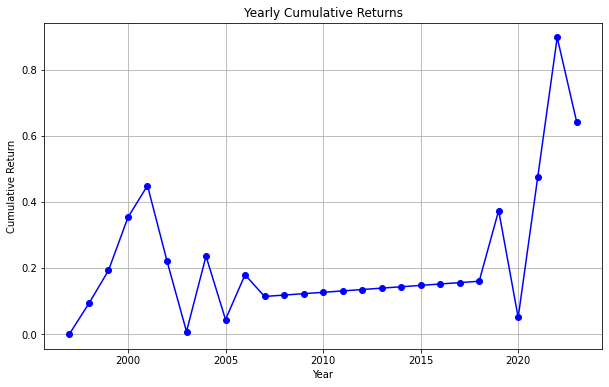

In [317]:
import matplotlib.pyplot as plt

# Plotting cumulative returns over time
plt.figure(figsize=(10, 6))
plt.plot(df_cumulative_returns['Year'], df_cumulative_returns['Cumulative_Return'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Yearly Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

# Display the plot
plt.grid(True)
plt.show()

In [191]:
def sum_vwertd_random_per_year(df):
    # Group by 'year' and select a random 'PERMNO' for each year
    results = []
    for year, group in df.groupby('Year'):
        # Randomly select one PERMNO for the year
        random_permno = group['PERMNO'].sample(n=1).values[0]
        
        # Sum the 'vwretd' for the selected PERMNO in that year
        selected_group = group[group['PERMNO'] == random_permno]
        total_vwretd = selected_group['vwretd'].sum()
        
        # Store the result
        results.append({'year': year, 'sum_vwretd': total_vwretd})
    
    return pd.DataFrame(results)

# Apply the function to the DataFrame
result_df = sum_vwertd_random_per_year(msf_data_f)

result_df['Cumulative_Return'] = result_df['sum_vwretd'].cumsum()

print(result_df)

    sum_vwretd  year  Cumulative_Return
0     0.198940  1996           0.198940
1     0.224547  1997           0.423487
2     0.228164  1998           0.651651
3     0.236750  1999           0.888401
4    -0.101413  2000           0.786988
5    -0.097475  2001           0.689513
6    -0.213548  2002           0.475965
7     0.295510  2003           0.771475
8     0.126031  2004           0.897506
9     0.074350  2005           0.971856
10    0.153375  2006           1.125231
11    0.075143  2007           1.200374
12   -0.445931  2008           0.754443
13    0.299449  2009           1.053892
14    0.181270  2010           1.235162
15    0.002353  2011           1.237515
16    0.152951  2012           1.390466
17    0.272104  2013           1.662570
18    0.103581  2014           1.766151
19   -0.009275  2015           1.756876
20    0.125366  2016           1.882242
21    0.189608  2017           2.071850
22   -0.054307  2018           2.017543
23    0.267766  2019           2.285309


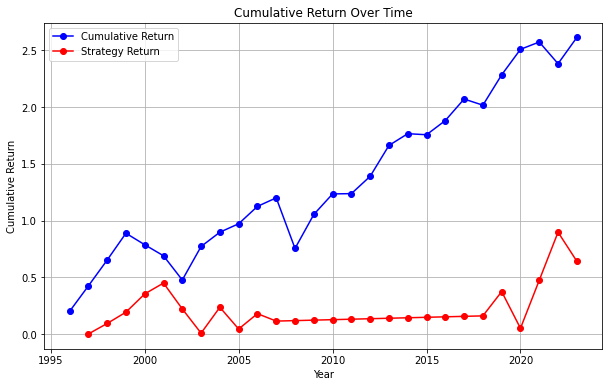

In [294]:
import matplotlib.pyplot as plt

# Plot the cumulative sum of 'Cumulative_Return'
plt.figure(figsize=(10, 6))
plt.plot(result_df['year'], result_df['Cumulative_Return'], marker='o', color='b', label='Cumulative Return')
plt.plot(df_cumulative_returns['Year'], df_cumulative_returns['Cumulative_Return'], marker='o', color='r', label='Strategy Return')

# Adding labels and title
plt.title('Cumulative Return Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [312]:
import numpy as np
import pandas as pd

# Sample data (Assuming 'returns' is a DataFrame with columns 'Portfolio_Return' and 'Market_Return')
# Replace with actual returns for your portfolio and market

strategy_returns = df_cumulative_returns['Cumulative_Return'] - df_cumulative_returns['Cumulative_Return'].shift(1)

data = {
    'year': df_cumulative_returns['Year'],
    'Portfolio_Return': (strategy_returns),
    'Market_Return': result_df['Cumulative_Return']
}
df = pd.DataFrame(data)

# Function to calculate Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.02):
    mean_return = returns.mean()
    std_dev = returns.std()
    return (mean_return - risk_free_rate) / std_dev

# Function to calculate Sortino Ratio
def sortino_ratio(returns, risk_free_rate=.02):
    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std()
    mean_return = returns.mean()
    return (mean_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

# Function to calculate Max Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Calculate metrics for both Portfolio and Market
portfolio_returns = df['Portfolio_Return']
market_returns = df['Market_Return']

portfolio_sharpe = sharpe_ratio(portfolio_returns)
market_sharpe = sharpe_ratio(market_returns)

portfolio_sortino = sortino_ratio(portfolio_returns)
market_sortino = sortino_ratio(market_returns)

portfolio_max_drawdown = max_drawdown(portfolio_returns)
market_max_drawdown = max_drawdown(market_returns)

# Display results
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.4f}")
print(f"Market Sharpe Ratio: {market_sharpe:.4f}")
print(f"Portfolio Sortino Ratio: {portfolio_sortino:.4f}")
print(f"Market Sortino Ratio: {market_sortino:.4f}")
print(f"Portfolio Max Drawdown: {portfolio_max_drawdown:.4f}")
print(f"Market Max Drawdown: {market_max_drawdown:.4f}")


Portfolio Sharpe Ratio: 0.0258
Market Sharpe Ratio: 1.8916
Portfolio Sortino Ratio: 0.0547
Market Sortino Ratio: nan
Portfolio Max Drawdown: -0.4505
Market Max Drawdown: 0.0000


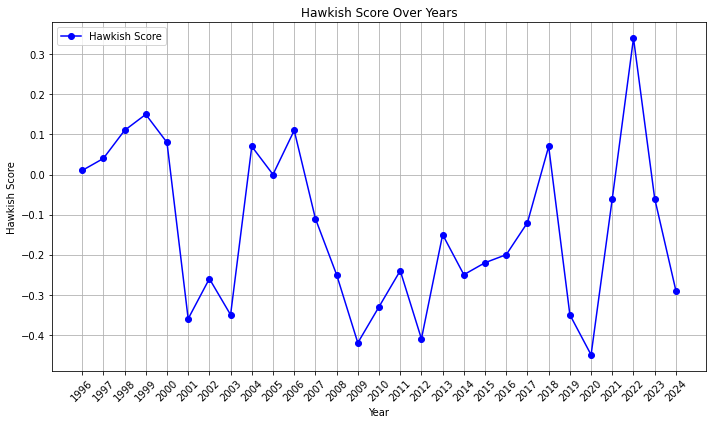

In [313]:
plt.figure(figsize=(10,6))
plt.plot(hawkishscore_result['year'], hawkishscore_result['hawkishness_score'], marker='o', color='b', linestyle='-', label='Hawkish Score')
plt.title('Hawkish Score Over Years')
plt.xlabel('Year')
plt.ylabel('Hawkish Score')
plt.grid(True)
plt.xticks(hawkishscore_result['year'], rotation=45)  # To make year labels readable
plt.legend()
plt.tight_layout()  # To ensure everything fits without overlap
plt.show()